In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [3]:
plt.rcParams["figure.figsize"] = (25,15)

In [4]:
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]

In [5]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [6]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [7]:
dflog=pd.read_csv("data/01_heights_weights_genders.csv")
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


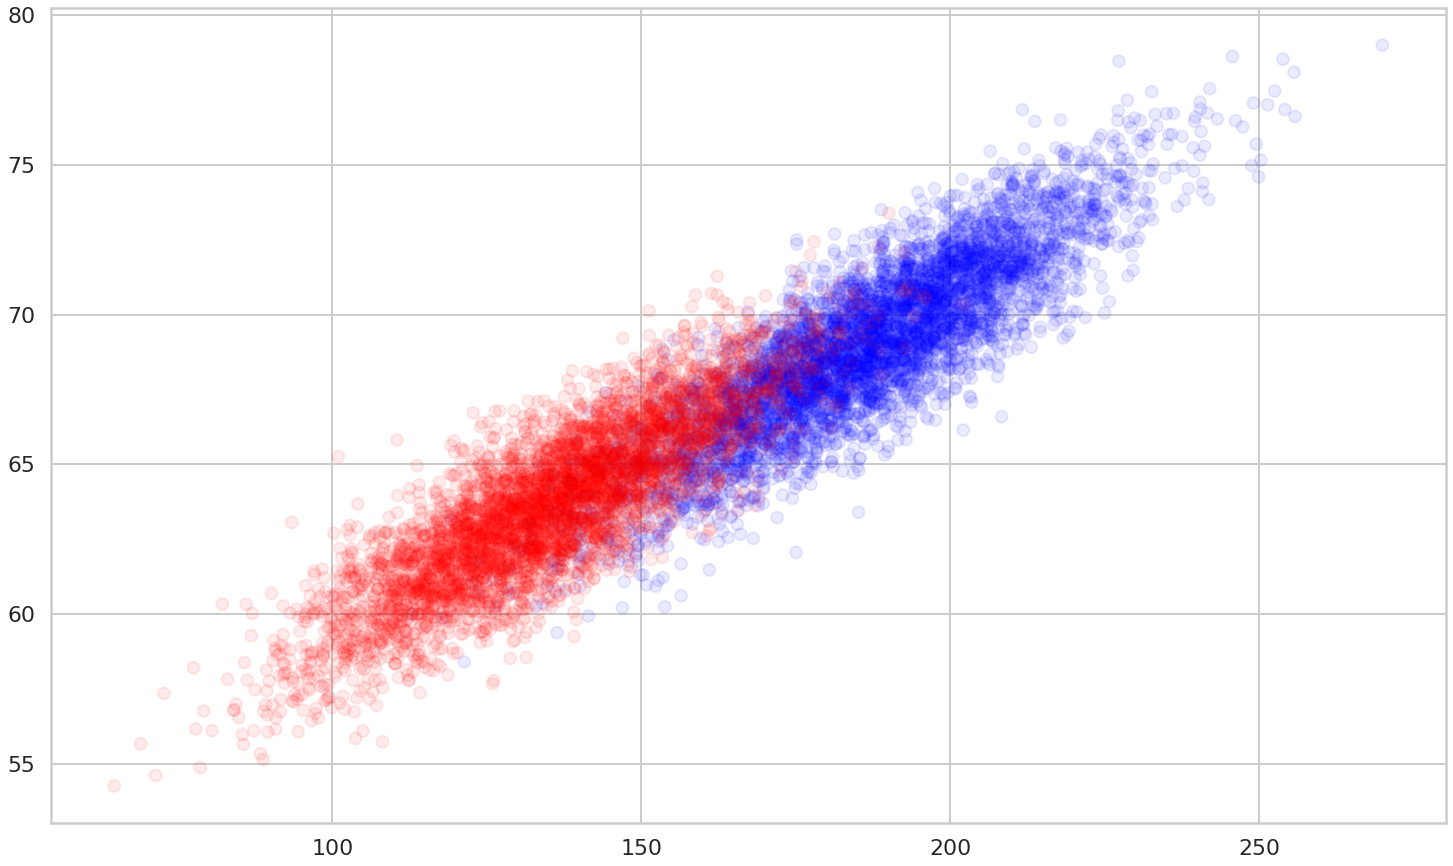

In [8]:
plt.scatter(dflog.Weight, dflog.Height, c=[cm_bright.colors[i] for i in dflog.Gender=="Male"], alpha=0.08)

In [23]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x):
        clf.fit(x[train], y[train])
        result += score_func(clf.predict(x[test]), y[test])
    return result / nfold

In [16]:
from sklearn.model_selection import train_test_split
Xlr, Xtestlr, ylr, ytestlr = train_test_split(dflog[['Height', 'Weight']].values, (dflog.Gender=="Male").values*1)

In [24]:
# The grid of parameters to search over
Cs = [0.001, 0.1, 1, 10, 100]
from sklearn.linear_model import LogisticRegression
max_score = 0

for C in Cs:
    clf = LogisticRegression(C=C)
    score = cv_score(clf, Xlr, ylr)
    
    if score > max_score:
        max_score = score
        best_c = C
        
print(max_score, best_c)

0.9190666666666667 0.1


/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22.

In [26]:
clfl = LogisticRegression(C=best_c)
clfl.fit(Xlr, ylr)
ypred=clfl.predict(Xtestlr)
accuracy_score(ypred, ytestlr)

/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9196

In [32]:
from sklearn.model_selection import GridSearchCV
clfl2=LogisticRegression(solver="lbfgs")
parameters = {"C":[0.0001, 0.001, 0.1, 1, 10, 100]}
fitmodel = GridSearchCV(clfl2, param_grid=parameters, cv=5, scoring="accuracy")
fitmodel.fit(Xlr, ylr)
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_,

(LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False), {'C': 1}, 0.9189333333333334)

In [35]:
clfl2 = LogisticRegression(C=fitmodel.best_params_['C'])
clfl2.fit(Xlr, ylr)
ypred2 = clfl2.predict(Xtestlr)
accuracy_score(ypred2, ytestlr)

/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9196

In [36]:
data = np.load("data/imag.pix.npy")
y = np.load("data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)
data.shape, y.shape

((87, 132342), (87,))

In [41]:
322*137*3

132342

In [37]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r, g, b = mat[0:size:3], mat[1:size:3], mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1], STANDARD_SIZE[0], 3), 'uint8') # 3 chanels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

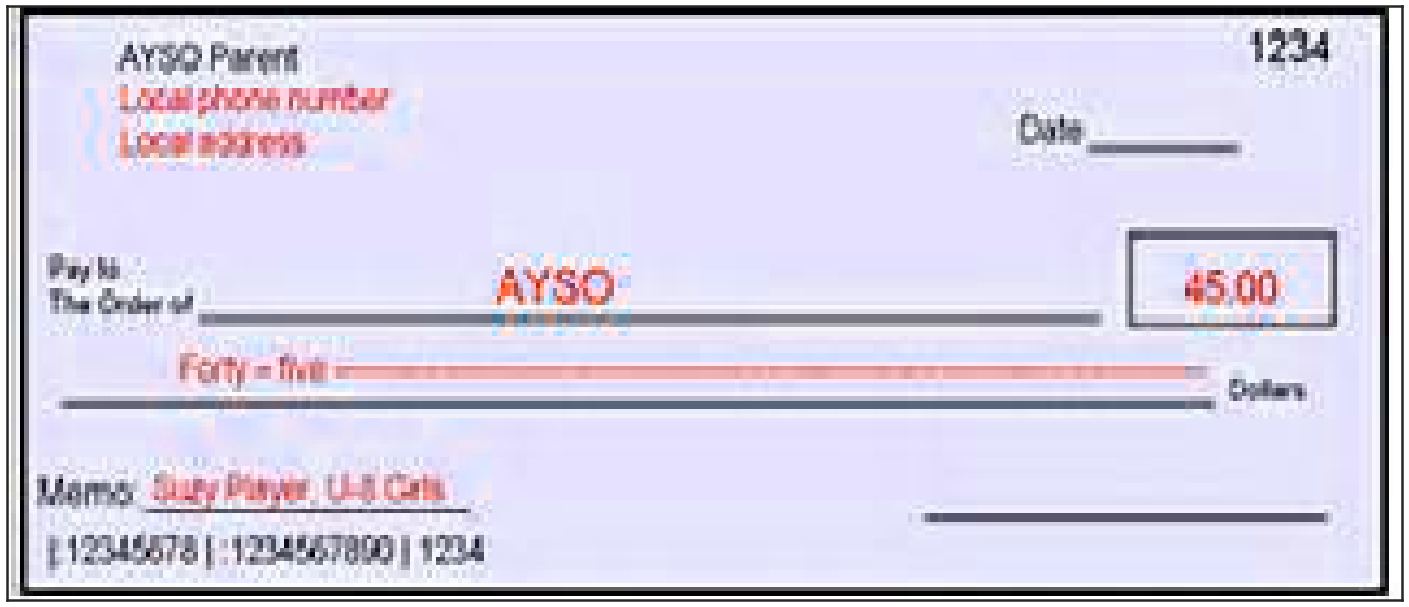

In [38]:
display_image(data[5])

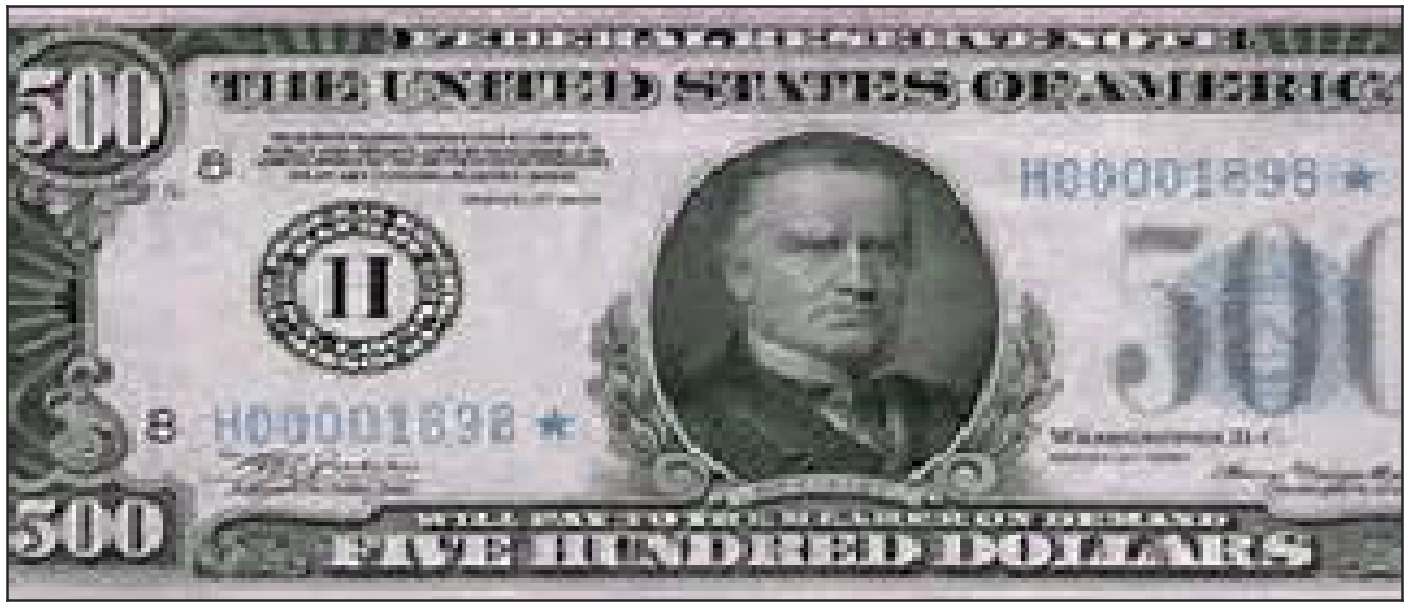

In [39]:
display_image(data[50])

In [42]:
data

array([[238, 238, 238, ..., 238, 238, 238],
       [140, 150, 152, ..., 255, 255, 255],
       [253, 253, 253, ..., 255, 255, 255],
       ...,
       [241, 243, 242, ..., 179, 173, 125],
       [255, 255, 221, ..., 255, 255, 243],
       [222, 207, 186, ..., 210, 199, 181]])

In [43]:
data.shape

(87, 132342)

In [82]:
data[:,:] - data.mean(axis=1)*

ValueError: operands could not be broadcast together with shapes (87,132342) (87,) 

In [46]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [50]:
X.shape

(87, 60)

In [47]:
print(pca.explained_variance_ratio_.sum())

0.9423918357516833


In [48]:
pca.explained_variance_ratio_*100

array([35.92596698,  6.29318801,  4.10778347,  3.11950952,  2.81695972,
        2.28831619,  2.10127948,  1.87404973,  1.73264634,  1.53023737,
        1.42159653,  1.31839385,  1.24701497,  1.1638172 ,  1.09958154,
        1.06073037,  1.00742823,  0.98023787,  0.96055434,  0.91535372,
        0.90184656,  0.852115  ,  0.83673575,  0.79691744,  0.75488853,
        0.72504763,  0.70820332,  0.67965343,  0.66090955,  0.64767677,
        0.62737236,  0.59469223,  0.58273113,  0.57432847,  0.57249474,
        0.55238967,  0.53848319,  0.53292281,  0.51617463,  0.49287532,
        0.48547914,  0.47703921,  0.4724719 ,  0.45572765,  0.44374345,
        0.43913778,  0.43360792,  0.42736103,  0.41818243,  0.40875715,
        0.40290417,  0.39118696,  0.38533448,  0.38032361,  0.3764299 ,
        0.36182303,  0.35395483,  0.34706918,  0.33507699,  0.33046882])

In [49]:
pca.explained_variance_ratio_.shape

(60,)

In [52]:
df = pd.DataFrame({"y":y, "label": np.where(y==1, "check", "dollor")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:, i]
df.head()

,y,label,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,1,check,-22536.362571,-2428.343978,-2133.774155,-328.327326,-1065.233716,79.759642,-425.029977,622.503461,-2490.265638,-858.375331,-1072.499428,277.114025,-1117.222063,712.783317,-786.701437,414.777787,-196.010954,472.101886,-429.824930,-608.892722,-590.800398,-265.283378,-990.790778,954.167639,1037.329754,569.517169,-48.825148,-114.066354,-519.190886,541.635537,-646.856995,68.213115,-733.887139,1288.805408,-544.203537,-112.748405,499.067137,297.128514,-245.993728,78.747098,-472.897751,788.991531,454.647179,-437.495796,480.127013,-305.693061,82.336864,231.516383,-585.905056,-314.575068,-566.531051,232.224112,404.226756,-118.031608,-81.163368,-467.117427,158.026630,-119.656633,-364.273076,-216.059133
1,1,check,-22226.658684,-709.255442,-288.825094,-1300.640771,-792.072898,217.413300,1076.803139,-2115.103330,-875.609474,-1124.203005,-343.319741,-42.999530,547.522147,357.356203,-1761.572914,-372.825699,813.472400,294.270441,-940.643580,154.329524,-1124.270340,509.754242,-814.585879,717.861069,286.175090,-115.112462,813.170050,1145.359478,-363.137751,115.389810,-854.374503,573.464265,310.340002,204.932086,-687.718534,-680.310079,-87.473239,-206.195981,-173.296769,-357.518367,121.038212,79.996772,706.801636,47.718285,279.972747,-0.428507,-87.762774,408.361516,1158.970058,225.593739,-650.814314,202.193699,232.901344,89.444280,718.740289,-580.325471,-179.564152,-71.187057,-45.998275,174.931412
2,1,check,-17364.260784,-4252.027625,793.800256,-1362.044496,-374.244288,3142.058516,2514.255778,1444.075142,-121.023585,-419.222136,-2082.986703,1717.673916,-724.230386,-1238.637620,-310.636969,-1058.883121,1384.955713,-800.508227,-2600.466833,-883.482363,3382.509209,-378.842370,-3412.519269,1336.433617,-4752.906771,1040.390214,2200.503727,-668.803582,1374.068683,-2158.544236,-642.259624,1701.260354,1819.908523,-3150.684309,-1057.445026,2127.144564,-3058.394137,3010.851344,889.340575,357.807380,1576.577339,-2916.010372,3957.261520,1528.390536,991.428506,522.524116,-844.289121,-1193.187597,-606.911800,-2399.872978,-3046.225222,-1505.569505,1514.155563,-1095.498875,-1717.637004,-2108.165310,-1403.931850,-442.793240,-235.462759,-1165.626327
3,1,check,-22847.256200,-900.590873,577.217172,-180.356084,-733.105476,-107.902691,1441.821587,-1070.053270,845.182026,-1391.189711,1470.050838,-725.068784,-577.623231,-259.790871,936.782248,173.436516,-295.876710,870.998784,-187.428837,1234.043472,552.904038,-182.067514,-347.846622,-370.023876,-937.065382,166.378435,1304.335460,74.612019,-254.925939,-445.010129,-179.093355,-57.567747,-6.815808,818.772991,-167.030617,711.617553,380.496709,339.423317,152.923645,-294.052934,1552.675051,-1066.432244,-866.621599,398.583824,352.525986,-504.540594,-581.434022,-365.104768,-988.293346,-1370.311201,-211.562962,-34.422928,-293.596171,-742.073861,-7.541767,455.133329,1791.672593,-587.391580,-580.100594,-1325.870538
4,1,check,-15868.672595,3259.490917,506.796137,-919.627423,2166.532309,-981.632512,-1669.691587,-391.112129,1735.926108,163.296963,-1626.832175,-556.467136,-863.385830,1723.261159,944.383192,-1132.139636,2140.398760,766.179906,-1097.365863,598.677755,-29.198308,91.660533,-506.629231,1100.107483,336.693588,-1232.430336,-698.001674,-701.177098,-139.956548,-902.864028,1022.897390,-3577.960215,2098.904140,-3387.171619,-1117.939807,-2202.994510,1927.120249,1934.054666,2534.747889,-556.947799,184.089426,1441.099727,1217.604186,-1269.024921,-449.539313,-768.873153,153.727698,1081.490403,3179.447699,1263.350530,-1321.145629,-2101.893656,-507.969519,-496.464135,3614.716746,2352.872050,-1299.370265,-1259.288384,-1923.663924,1492.127769


In [53]:
df.shape

(87, 62)

In [55]:
pca.components_

array([[-0.00137942, -0.00164105, -0.00188562, ..., -0.00164061,
        -0.00181242, -0.00208118],
       [-0.00936683, -0.00896847, -0.00771694, ..., -0.00910723,
        -0.00876363, -0.0080063 ],
       [-0.00016054, -0.00011413, -0.00049585, ..., -0.00074512,
        -0.00091883, -0.00120923],
       ...,
       [ 0.00263782,  0.00098292,  0.00104924, ...,  0.0011543 ,
        -0.0009171 , -0.00132993],
       [-0.00117573, -0.00164466, -0.00338239, ..., -0.00040673,
        -0.00087824, -0.00047799],
       [-0.0013688 , -0.00123212, -0.00231106, ..., -0.00157224,
        -0.00207821, -0.00414561]])

In [56]:
pca.components_.shape

(60, 132342)

In [57]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

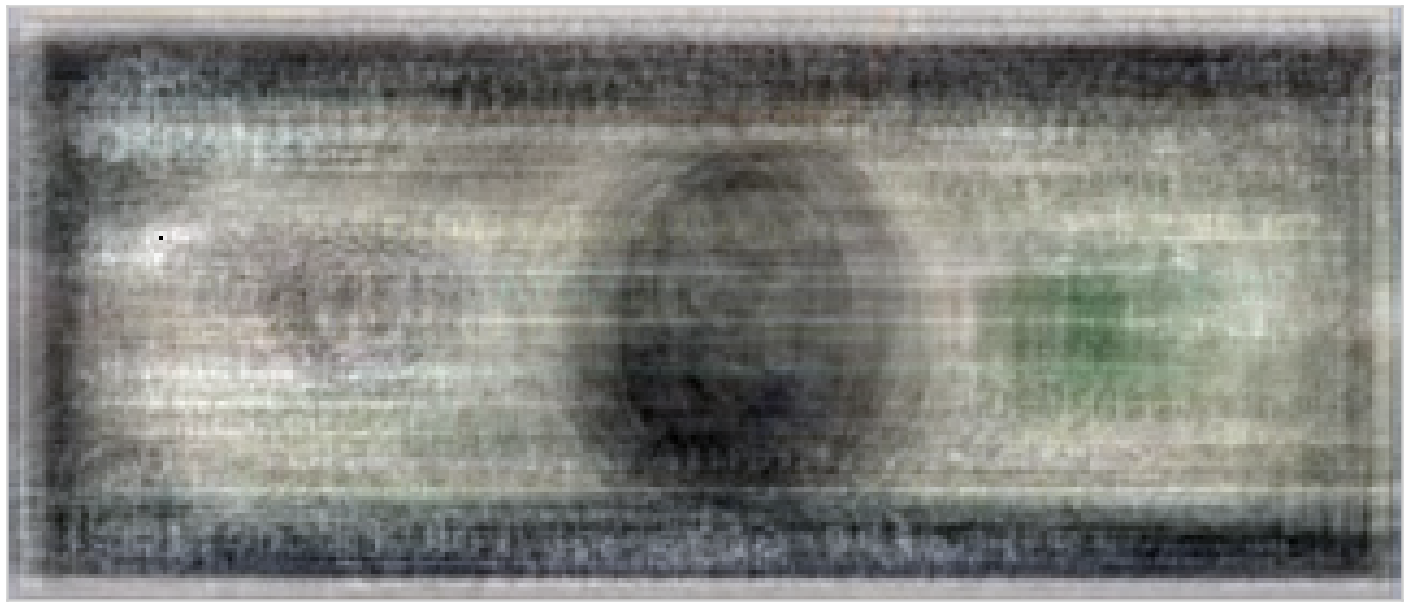

In [58]:
display_component(pca, 0)

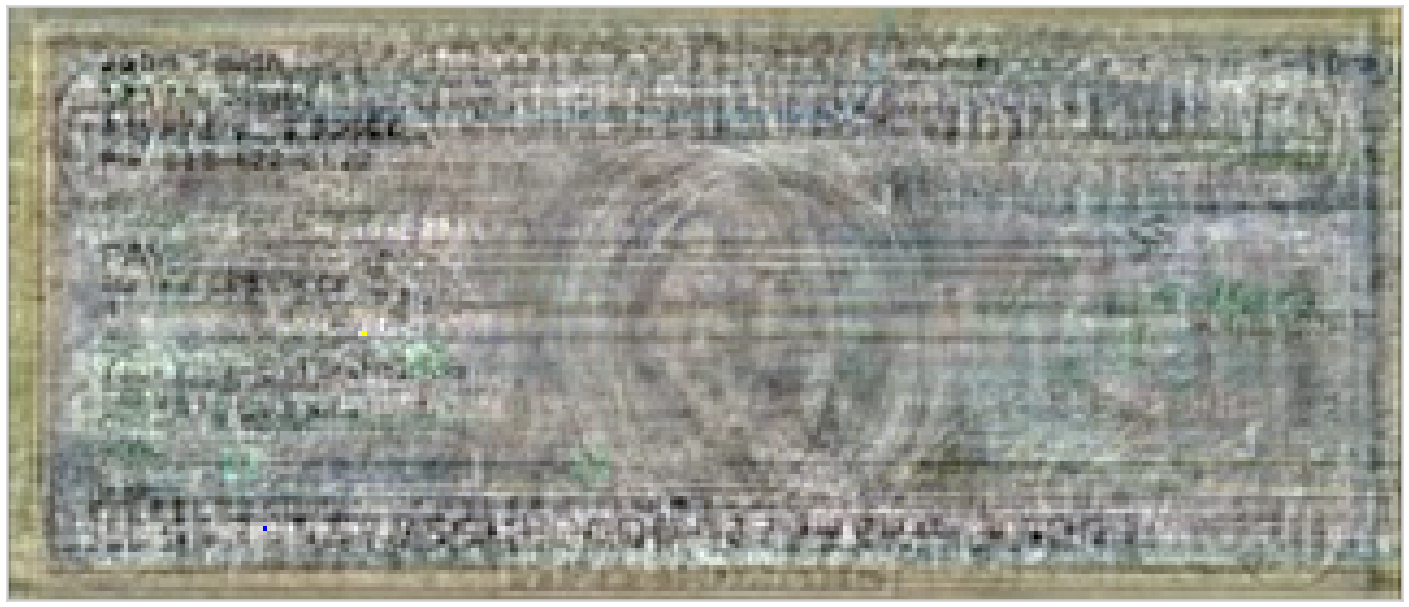

In [60]:
display_component(pca, 59)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


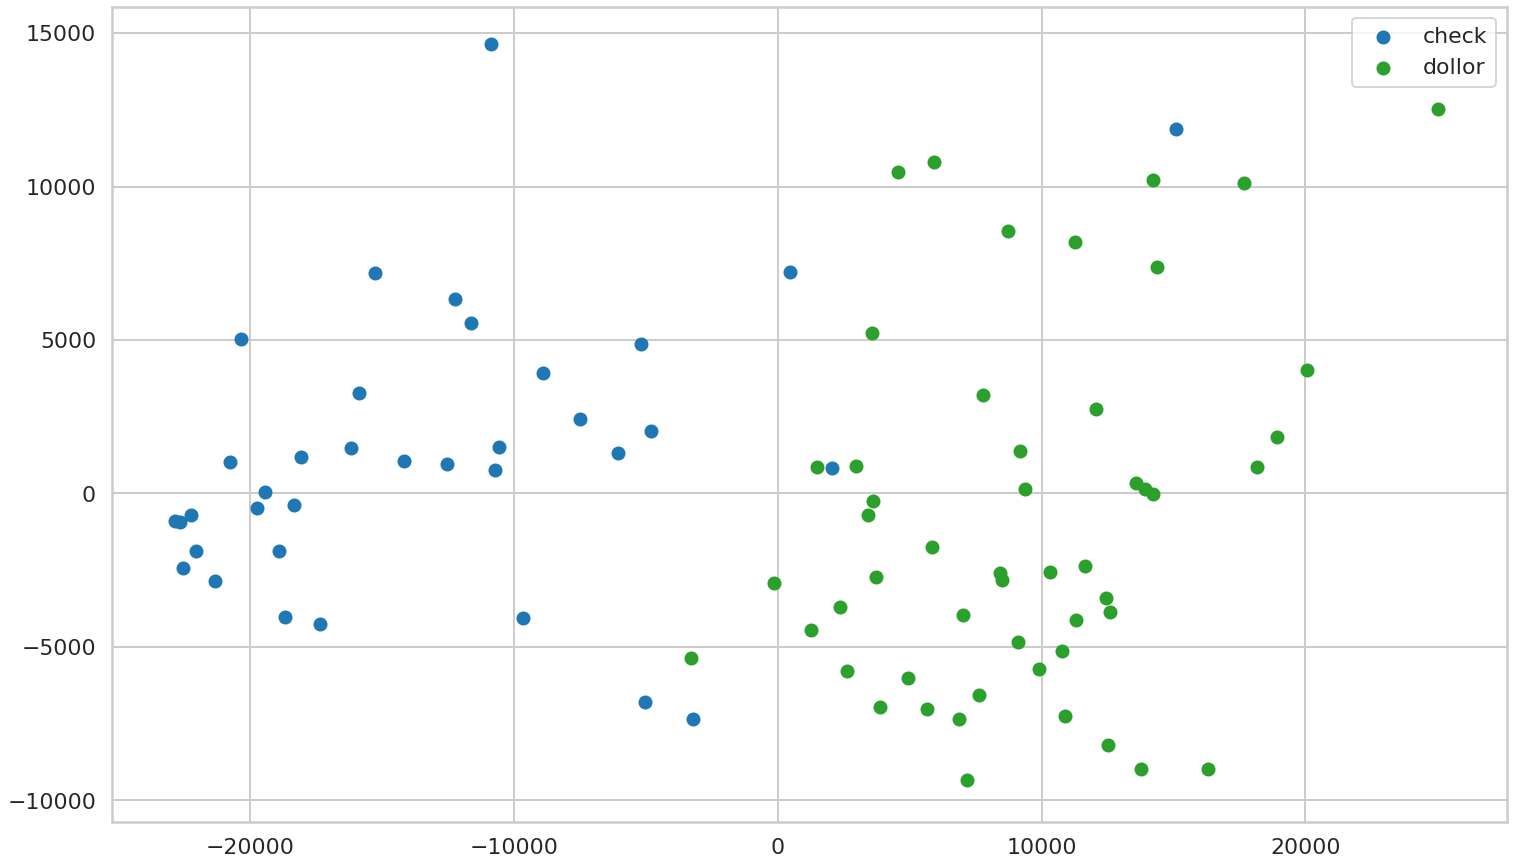

In [61]:
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label'] == label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

ys = df['y'].astype(int).values
subdf = df[['pc1', 'pc2']]
subdfstd = (subdf - subdf.mean())/subdf.std()  # standardize the data
Xs=subdfstd.values

def classify(X, y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size = train_size)
    clf = KNeighborsClassifier(nbrs)
    clf = clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall = np.concatenate((Xtrain, Xtest))
    if plotit:
        print("Accuracy on the training data: %0.2f" % (training_accuracy))
        print("Accuracy on the test data: %0.2f" % (test_accuracy))
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

Accuracy on the training data: 1.00
Accuracy on the test data: 0.89


(1, 1.0, 0.8857142857142857)

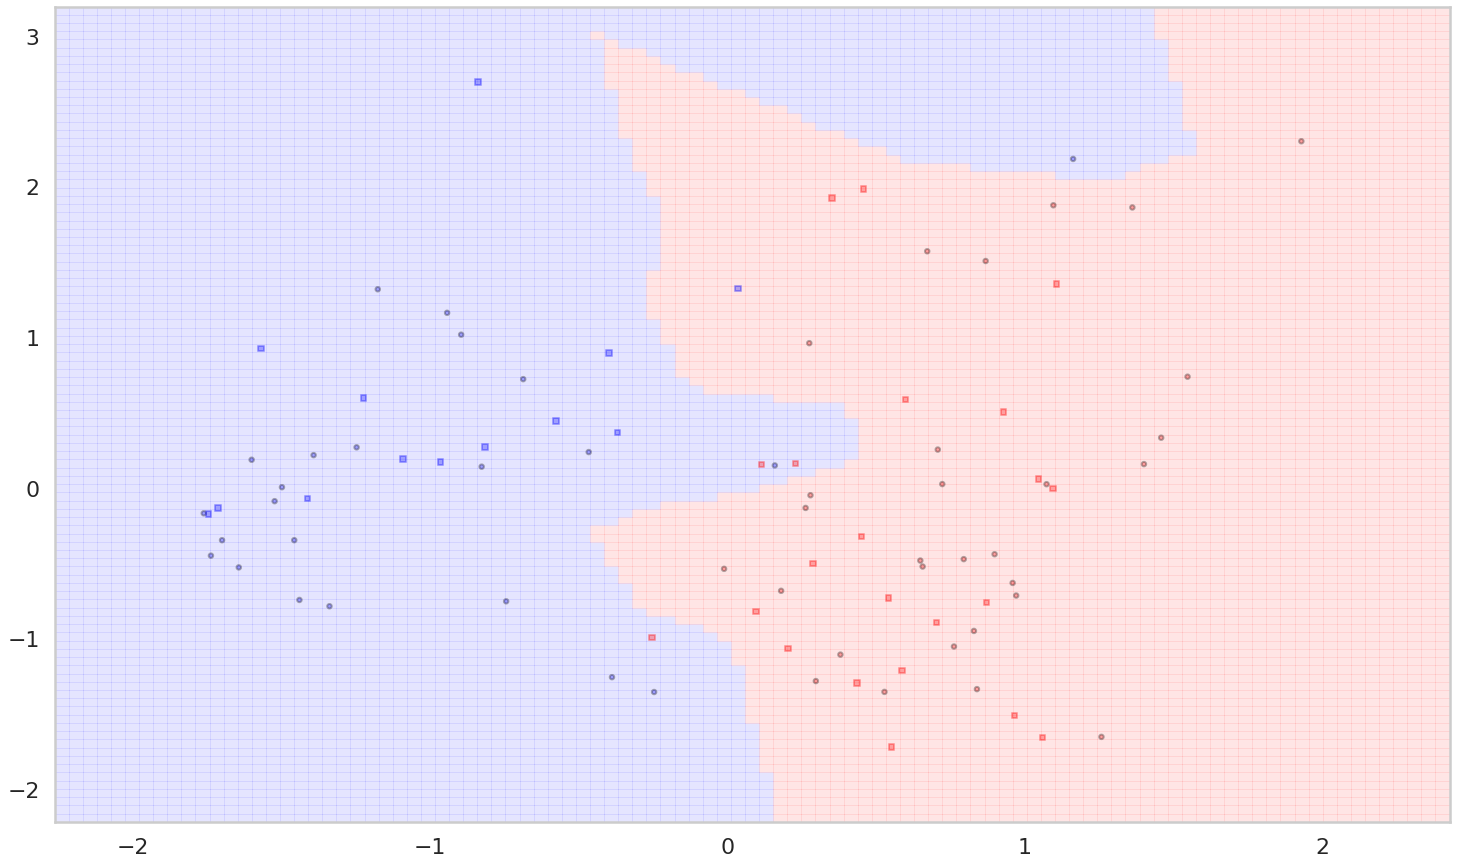

In [73]:
classify(Xs, ys, 1)

In [83]:
fits = {}
for k in np.arange(1, 45, 1):
    fits[k] = []
    for i in range(200):
        fits[k].append(classify(Xs, ys, k, False))
nbrs = np.arange(1, 45, 1)
fmeanstr = np.array([1. - np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1. - np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])


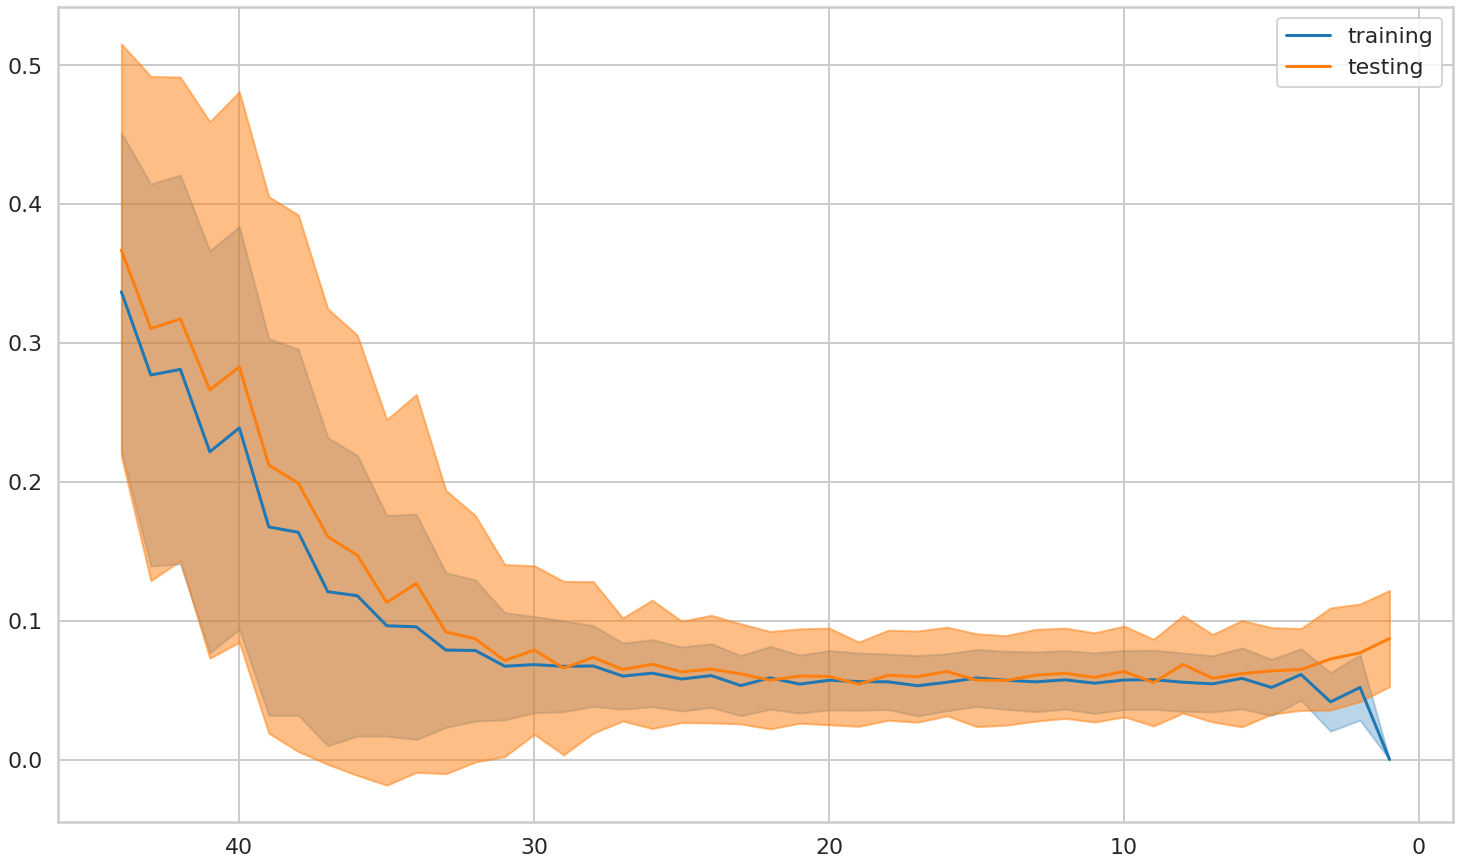

In [84]:
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste-fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)
plt.legend();

In [85]:
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("Best Params: ", gs.best_params_)
    best = gs.best_estimator_
    return best

In [89]:
from sklearn.model_selection import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf = indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf = clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: %0.2f" % (training_accuracy))
    print("Accuracy on test data: %0.2f" % (test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

In [90]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1, 40, 2)}, df, ['pc1', 'pc2'], 'label', 'check')

Best Params:  {'n_neighbors': 5}
Accuracy on training data: 0.96
Accuracy on test data: 0.94


/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [91]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1, 40, 2)}, df, ['pc1', 'pc2'], 'label', 'check')

Best Params:  {'n_neighbors': 1}
Accuracy on training data: 1.00
Accuracy on test data: 0.89


/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [92]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1, 40, 2)}, df, ['pc1', 'pc2'], 'label', 'check')

Best Params:  {'n_neighbors': 3}
Accuracy on training data: 0.97
Accuracy on test data: 0.89


/home/bird/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


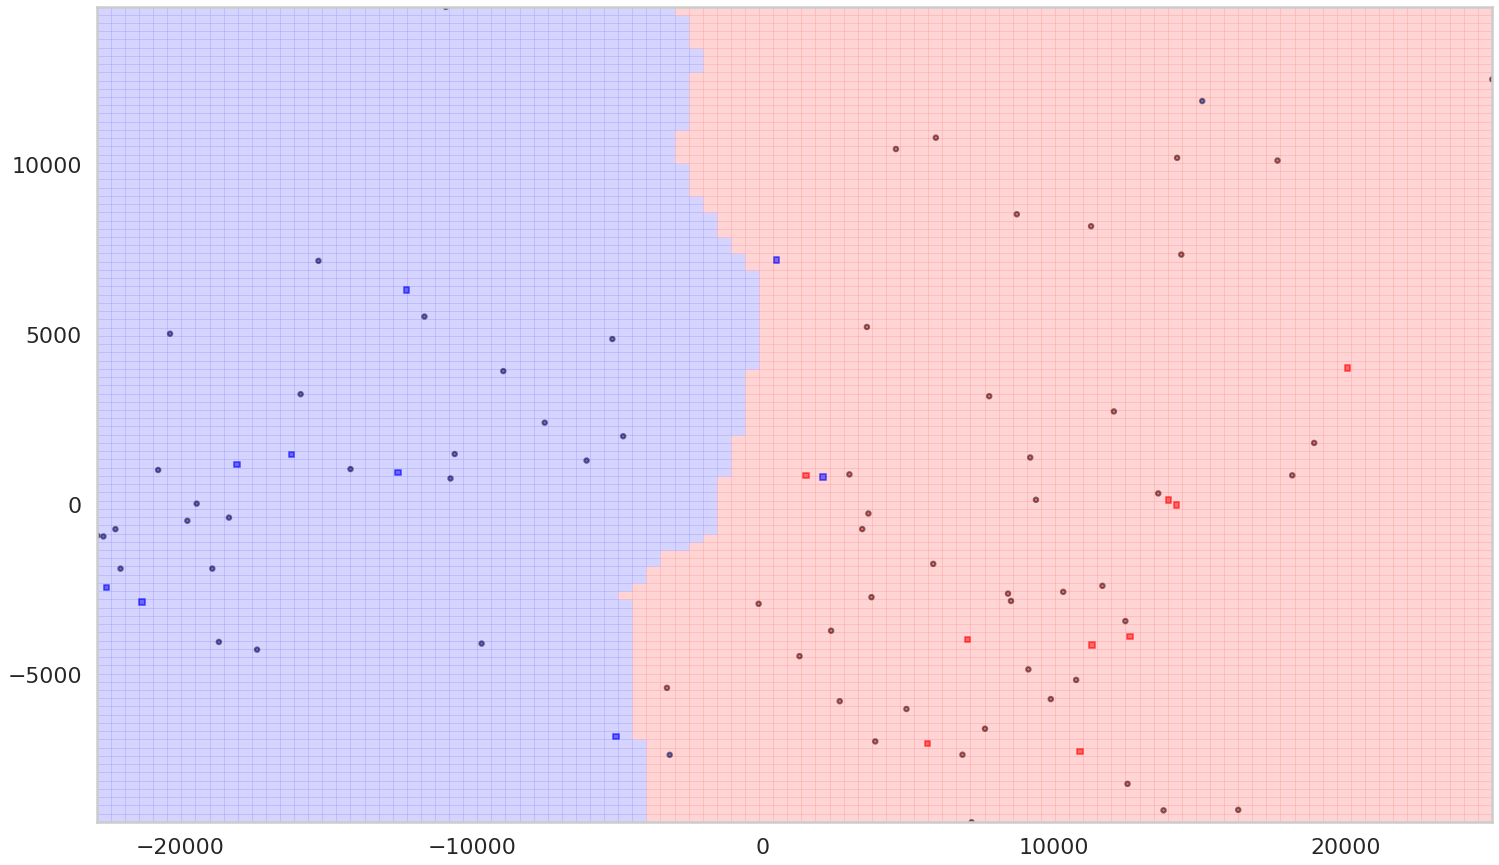

In [93]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

/home/bird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'axes'
  """
/home/bird/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'axes'
  


TypeError: clabel() got an unexpected keyword argument 'axes'

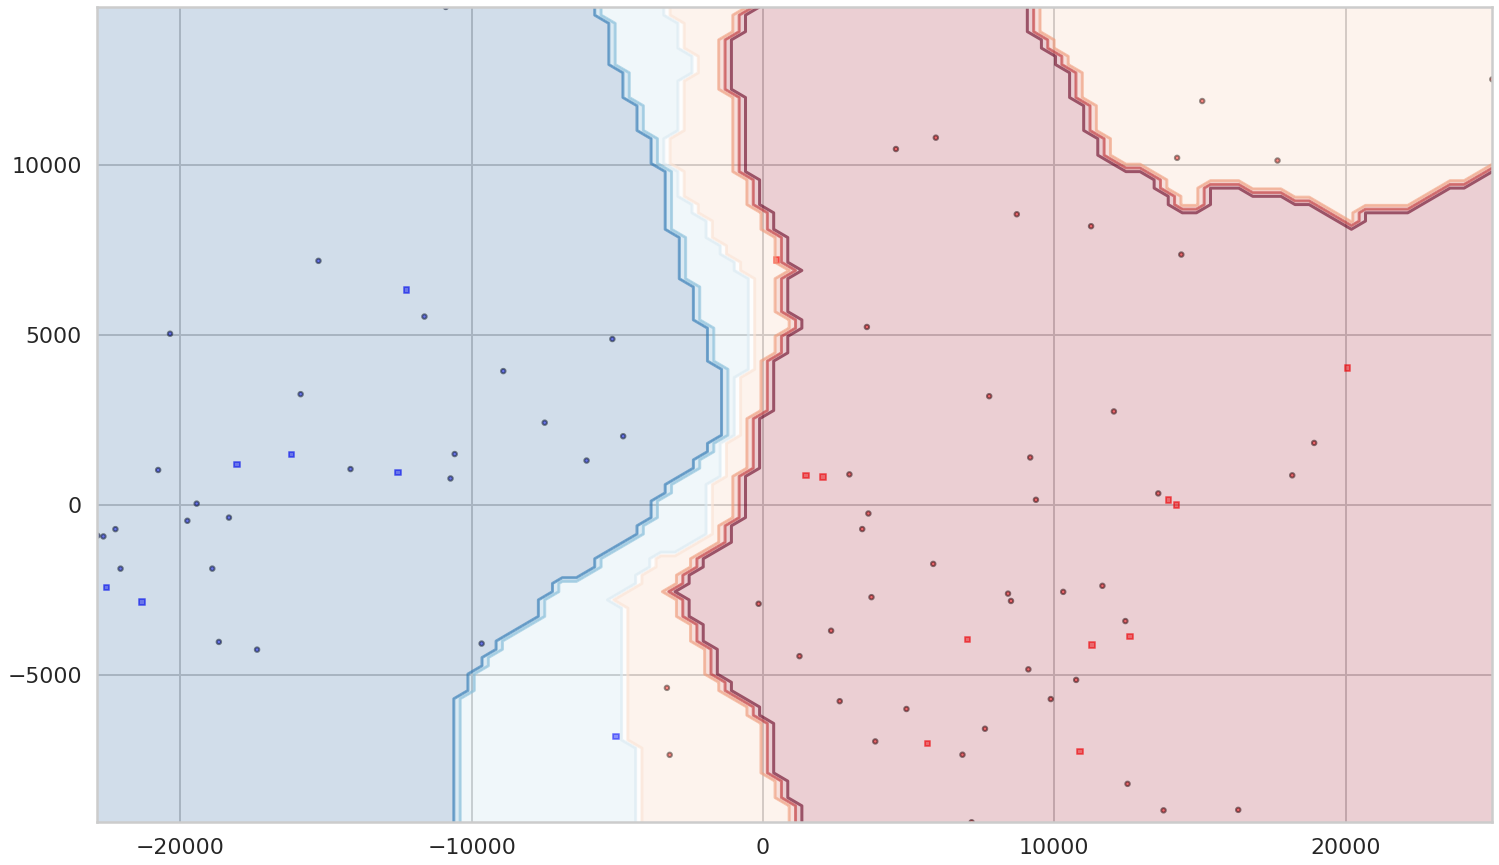

In [94]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

In [95]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(ytest, bestcv.predict(Xtest),)

array([[9, 0],
       [2, 7]])

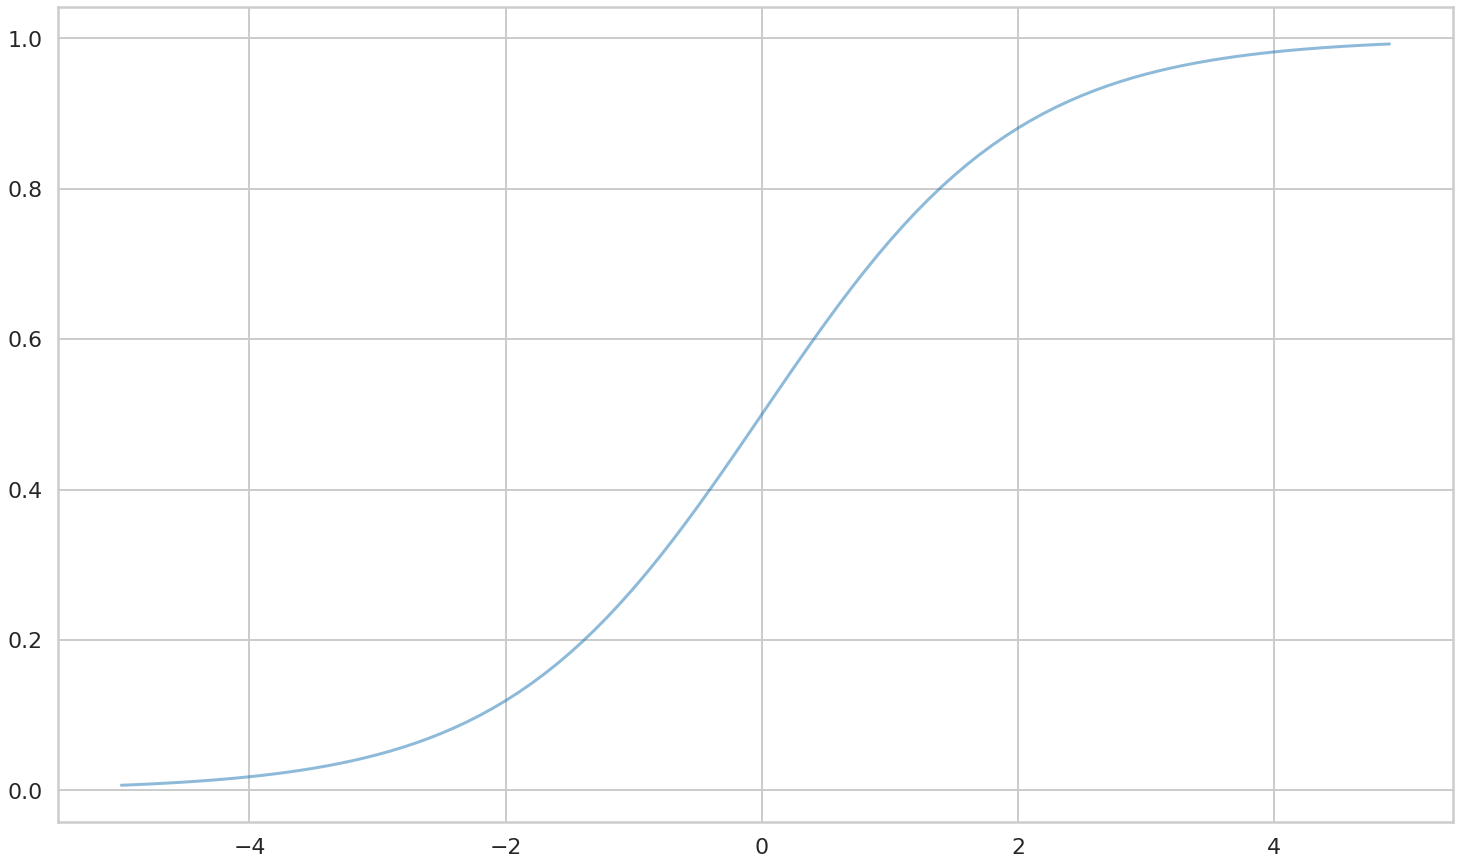

In [96]:
h = lambda z: 1./(1+np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5)

In [97]:
dflog.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


In [101]:
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l = do_classify(LogisticRegression(solver='lbfgs'), {"C": [0.01, 0.1, 1, 10, 100]}, dflog, ['Weight', 'Height'], 'Gender', 'Male')

Best Params:  {'C': 0.1}
Accuracy on training data: 0.92
Accuracy on test data: 0.91


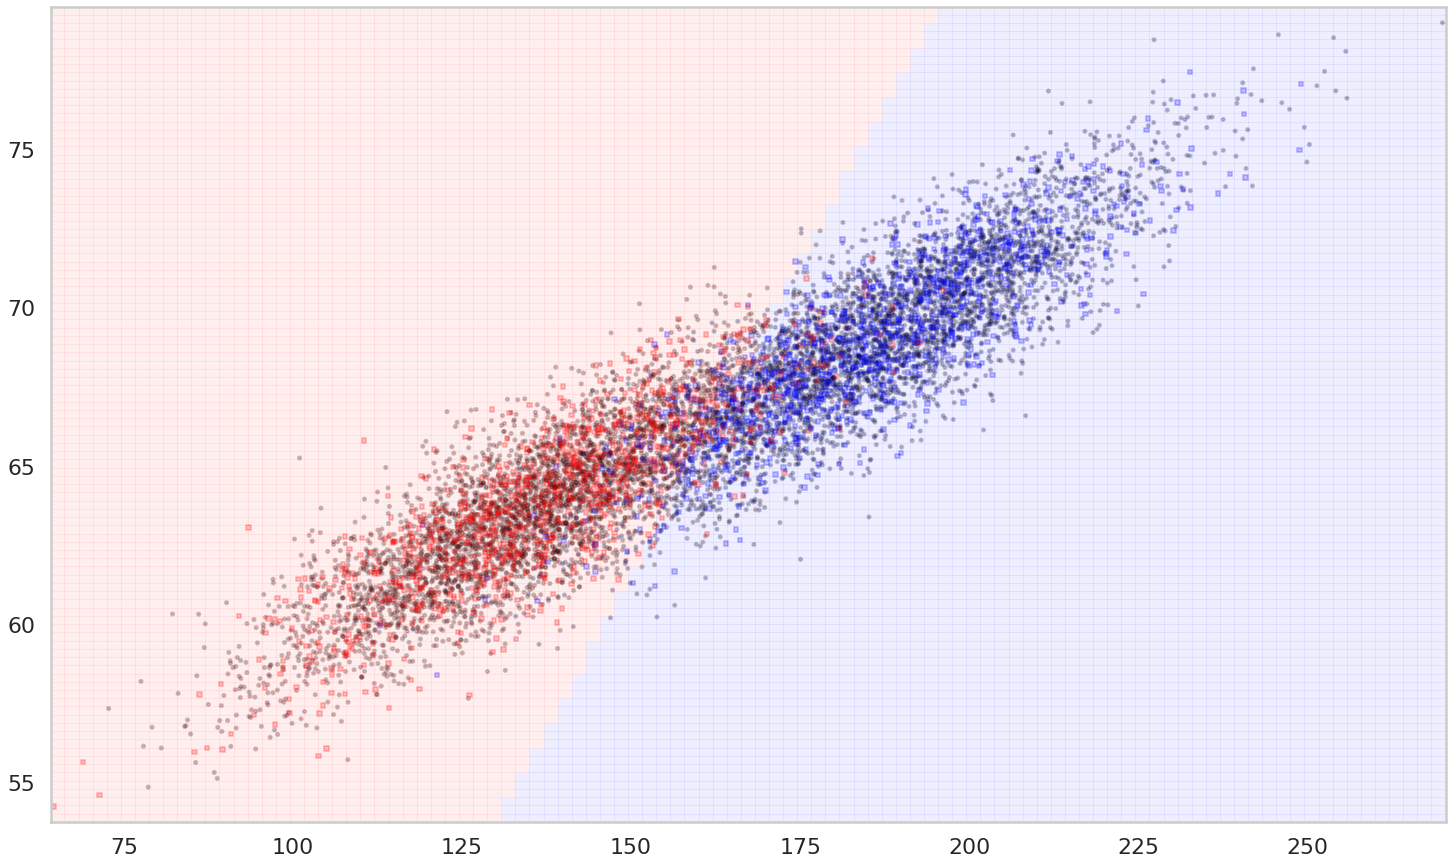

In [102]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain_l, Xtest_l, ytrain_l, ytest_l, clf_l, alpha=0.2);